In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
import sys
sys.path.append("../")

In [6]:
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

from src.analysis import coherence
from src.analysis.state_space import prepare_state_trajectory, StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechEquivalenceDataset

In [7]:
model_dir = "outputs/models/timit/w2v2_6/rnn_8-weightdecay0.01/word_broad_10frames"
output_dir = "."
dataset_path = "outputs/preprocessed_data/timit"
equivalence_path = "outputs/equivalence_datasets/timit/w2v2_6/word_broad_10frames/equivalence.pkl"
hidden_states_path = "outputs/hidden_states/timit/w2v2_6/hidden_states.pkl"
state_space_specs_path = "outputs/state_space_specs/timit/w2v2_6/state_space_specs.pkl"
embeddings_path = "outputs/model_embeddings/timit/w2v2_6/rnn_8-weightdecay0.01/word_broad_10frames/embeddings.npy"

metric = "cosine"

# Retain words with N or more instances
retain_n = 10

In [8]:
with open(embeddings_path, "rb") as f:
    model_representations: np.ndarray = np.load(f)
with open(equivalence_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = torch.load(f)
with open(state_space_specs_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = torch.load(f)["word"]
assert state_space_spec.is_compatible_with(model_representations)

In [9]:
drop_idxs = [idx for idx, target_frames in enumerate(state_space_spec.target_frame_spans)
               if len(target_frames) < retain_n]
state_space_spec = state_space_spec.drop_labels(drop_idxs)

In [11]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec, pad=np.nan)
lengths = [np.isnan(traj_i[:, :, 0]).argmax(axis=1) for traj_i in trajectory]

In [14]:
len(trajectory), np.concatenate(lengths).mean()

(590, 12.599139818177136)

## Estimate within-word distance

In [15]:
within_distance, within_distance_offset = \
    coherence.estimate_within_distance(trajectory, lengths, state_space_spec, metric=metric)

  0%|          | 0/590 [00:00<?, ?it/s]

In [17]:
within_distance_df = pd.DataFrame(within_distance, index=pd.Index(state_space_spec.labels, name="word")) \
    .reset_index() \
    .melt(id_vars=["word"], var_name="frame", value_name="distance")

In [18]:
within_distance_offset_df = pd.DataFrame(within_distance_offset, index=pd.Index(state_space_spec.labels, name="word")) \
    .reset_index() \
    .melt(id_vars=["word"], var_name="frame", value_name="distance")

## Estimate between-word distance

In [19]:
between_distance, between_distance_offset = \
    coherence.estimate_between_distance(trajectory, lengths, state_space_spec,
                                        metric=metric)

  0%|          | 0/590 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:17: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
between_distances_df = pd.DataFrame(np.nanmean(between_distance, axis=-1),
                                    index=pd.Index(state_space_spec.labels, name="word")) \
    .reset_index() \
    .melt(id_vars=["word"], var_name="frame", value_name="distance")

/tmp/ipykernel_1133685/1636428382.py:1: RuntimeWarning: Mean of empty slice
  between_distances_df = pd.DataFrame(np.nanmean(between_distance, axis=-1),


In [21]:
between_distances_offset_df = pd.DataFrame(np.nanmean(between_distance_offset, axis=-1),
                                    index=pd.Index(state_space_spec.labels, name="word")) \
    .reset_index() \
    .melt(id_vars=["word"], var_name="frame", value_name="distance")

/tmp/ipykernel_1133685/3903637063.py:1: RuntimeWarning: Mean of empty slice
  between_distances_offset_df = pd.DataFrame(np.nanmean(between_distance_offset, axis=-1),


## Together

In [22]:
merged_df = pd.concat([within_distance_df.assign(type="within"), between_distances_df.assign(type="between")])
merged_df.to_csv(Path(output_dir) / "distances.csv", index=False)
merged_df

,word,frame,distance,type
0,she,0,0.282840,within
1,had,0,0.098066,within
2,your,0,0.033807,within
3,dark,0,0.014401,within
4,suit,0,0.008676,within
...,...,...,...,...
36575,overalls,61,NaN,between
36576,greg,61,NaN,between
36577,potatoes,61,NaN,between
36578,i'd,61,NaN,between


Text(0, 0.5, 'Cosine distance')

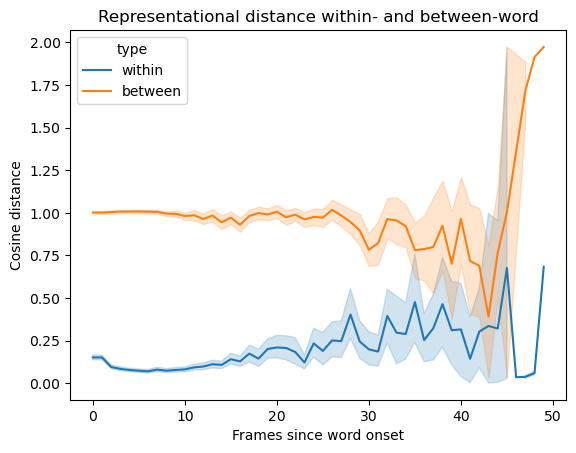

In [23]:
ax = sns.lineplot(data=merged_df.dropna(), x="frame", y="distance", hue="type")
ax.set_title("Representational distance within- and between-word")
ax.set_xlabel("Frames since word onset")
ax.set_ylabel(f"{metric.capitalize()} distance")

In [ ]:
merged_offset_df = pd.concat([within_distance_offset_df.assign(type="within"),
                              between_distances_offset_df.assign(type="between")])
merged_offset_df.to_csv(Path(output_dir) / "distances_aligned_offset.csv", index=False)
merged_offset_df

In [ ]:
ax = sns.lineplot(data=merged_offset_df.dropna(),
                  x="frame", y="distance", hue="type")
ax.set_title("Representational distance within- and between-word")
ax.set_xlabel("Frames before word offset")
ax.set_ylabel(f"{metric.capitalize()} distance")
ax.set_xlim((0, np.percentile(np.concatenate(lengths), 95)))

## Estimate distance by grouping features

### Onset

In [ ]:
onsets = [word[0] for word in state_space_spec.labels]

onset_distance_df, onset_distance_offset_df = coherence.estimate_category_within_between_distance(
    trajectory, lengths, onsets, metric=metric, labels=state_space_spec.labels
)

In [ ]:
onset_distance_df.to_csv(Path(output_dir) / "distances-grouped_onset.csv", index=False)

In [ ]:
ax = sns.lineplot(data=onset_distance_df.dropna(), x="frame", y="distance", hue="type")
ax.set_title("Representational distance by onset match/mismatch")
ax.set_xlabel("Frames since word onset")
ax.set_ylabel(f"{metric.capitalize()} distance")

In [ ]:
onset_distance_offset_df["time"] = (onset_distance_offset_df.frame - 1) / 20
onset_distance_offset_df.to_csv(Path(output_dir) / "distances-grouped_onset_aligned_offset.csv", index=False)

### Offset

In [ ]:
offsets = [word[-1] for word in state_space_spec.labels]

offset_distance_df, offset_distance_offset_df = coherence.estimate_category_within_between_distance(
    trajectory, lengths, offsets, metric=metric, labels=state_space_spec.labels
)

In [ ]:
offset_distance_df["time"] = (offset_distance_df.frame - 1) / 20
offset_distance_df.to_csv(Path(output_dir) / "distances-grouped_offset.csv", index=False)

In [ ]:
offset_distance_offset_df["time"] = (offset_distance_offset_df.frame - 1) / 20
offset_distance_offset_df.to_csv(Path(output_dir) / "distances-grouped_offset_aligned_offset.csv", index=False)

In [ ]:
ax = sns.lineplot(data=offset_distance_offset_df.dropna(), x="frame", y="distance", hue="type")
ax.set_title("Representational distance by offset match/mismatch")
ax.set_xlabel("Frames before word offset")
ax.set_ylabel(f"{metric.capitalize()} distance")

## Model-free exploration

In [61]:
knn_window_size = 10

In [67]:
knn_references = np.concatenate([np.nanmean(traj_i[:, :knn_window_size, :], axis=1)  # .reshape((traj_i.shape[0], -1))
                                 for traj_i in trajectory])
knn_reference_ids = np.stack([(state_space_spec.labels[idx], j)
                                    for idx in range(len(trajectory)) for j in range(trajectory[idx].shape[0])])

In [68]:
knn_instances = np.random.choice(len(knn_references), 10, replace=False)

In [69]:
assert knn_references.shape[0] == knn_reference_ids.shape[0]

In [70]:
from scipy.spatial.distance import cdist, pdist, squareform

In [71]:
for knn_instance in knn_instances:
    ref_embedding = knn_references[knn_instance]
    knn_instance_results = cdist(knn_references, ref_embedding[None, :], metric=metric).ravel()

    print(knn_reference_ids[knn_instance])
    print("Nearest neighbors:")
    print(knn_reference_ids[knn_instance_results.argsort()[1:10]])
    print("Furthest neighbors:")
    print(knn_reference_ids[(-knn_instance_results).argsort()[:10]])
    print()

['you' '15']
Nearest neighbors:
[['eating' '21']
 ['he' '338']
 ['is' '104']
 ['your' '4']
 ['your' '424']
 ['youngsters' '1']
 ['he' '245']
 ['he' '64']
 ['he' '39']]
Furthest neighbors:
[['film' '9']
 ['from' '64']
 ['for' '286']
 ['by' '44']
 ['pie' '20']
 ['for' '142']
 ['the' '828']
 ['fill' '9']
 ['for' '355']
 ['three' '13']]

['wash' '475']
Nearest neighbors:
[['wash' '156']
 ['wash' '462']
 ['water' '545']
 ['water' '84']
 ['water' '580']
 ['rag' '550']
 ['water' '313']
 ['water' '386']
 ['water' '354']]
Furthest neighbors:
[['caused' '28']
 ['top' '5']
 ['see' '5']
 ['small' '22']
 ['still' '4']
 ['talk' '5']
 ['study' '3']
 ['to' '66']
 ['simple' '7']
 ['see' '7']]

['caused' '2']
Nearest neighbors:
[['coffee' '0']
 ['colorful' '5']
 ['to' '1222']
 ['club' '5']
 ['suit' '504']
 ['caused' '19']
 ['job' '13']
 ['try' '4']
 ['cost' '11']]
Furthest neighbors:
[['more' '25']
 ['monday' '17']
 ['more' '72']
 ['more' '39']
 ['milk' '15']
 ['more' '64']
 ['mom' '4']
 ['might' '9']
 

### RSA, collapsed over instances

In [79]:
rsa_ids = np.unique(knn_reference_ids[:, 0])
rsa_references = np.stack([np.nanmean(knn_references[knn_reference_ids[:, 0] == rsa_id], axis=0)
                            for rsa_id in rsa_ids])
rsa_distances = squareform(pdist(rsa_references, metric=metric))
rsa_distances = pd.DataFrame(rsa_distances, index=rsa_ids, columns=rsa_ids)

<Axes: >

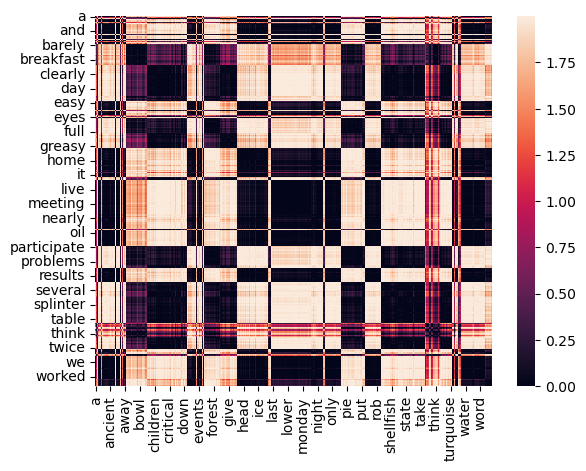

In [80]:
sns.heatmap(rsa_distances)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


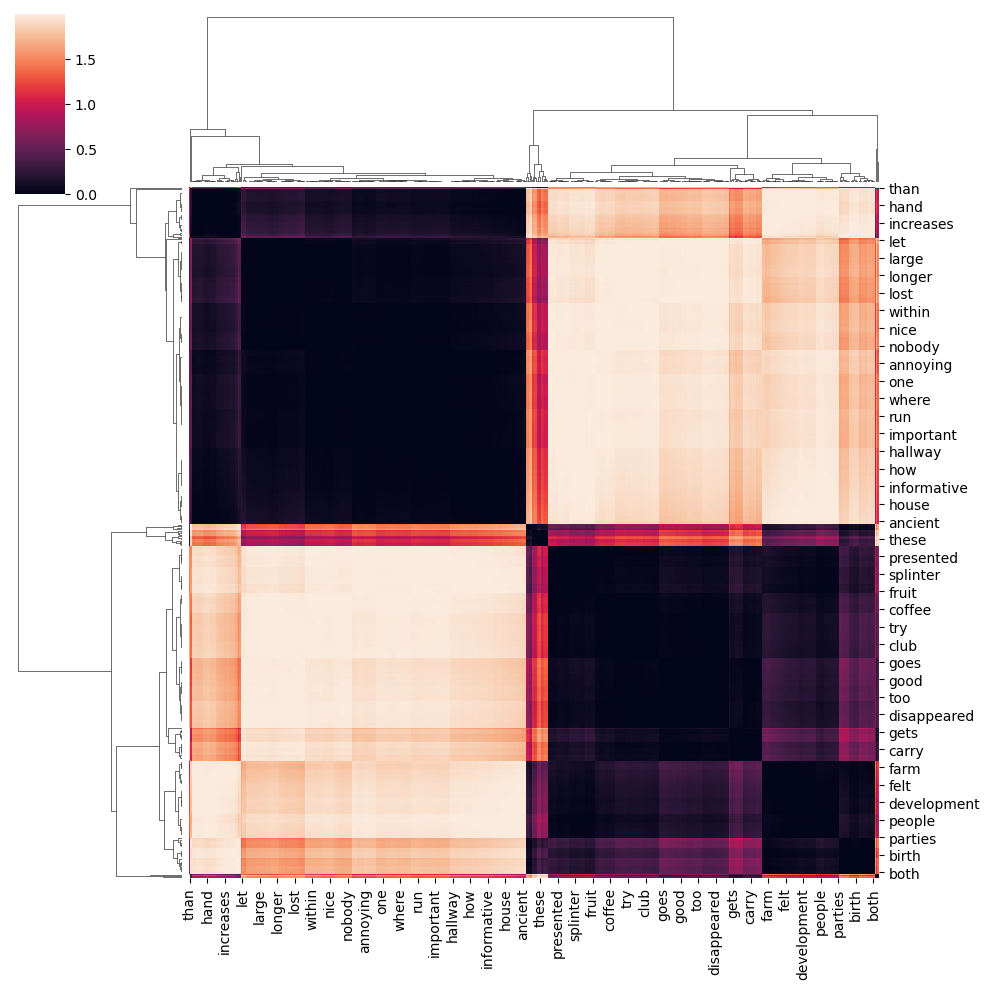

In [81]:
sns.clustermap(rsa_distances)

In [111]:
# Print closest pairs
rsa_distances.values[np.diag_indices(len(rsa_distances))] = rsa_distances.values.flatten().mean()
closest_pair_idxs = rsa_distances.values.ravel().argsort()
closest_pair_idxs = np.stack(np.unravel_index(closest_pair_idxs, rsa_distances.shape)).T
closest_pair_idxs = closest_pair_idxs[closest_pair_idxs[:, 0] != closest_pair_idxs[:, 1]]

print_n = 50
for x, y in closest_pair_idxs[:print_n]:
    if x < y:
        print(rsa_distances.index[x], rsa_distances.columns[y], rsa_distances.values[x, y])
print("---")
for x, y in closest_pair_idxs[-print_n:]:
    if x > y:
        print(rsa_distances.index[x], rsa_distances.columns[y], rsa_distances.values[x, y])

clearly suit 3.562660072287116e-06
comes course 4.959873025067729e-06
high however 5.111908625621275e-06
costumes table 7.691322028158254e-06
only over 8.092309696006161e-06
when will 8.436497226926853e-06
long love 8.640575093199487e-06
allow almost 9.738202767839432e-06
one well 1.0364961823494667e-05
cleaners costumes 1.1329090210843162e-05
cleaners students 1.1986258486640367e-05
one what 1.3321462519533256e-05
come common 1.3403774490439169e-05
nine no 1.350743692751788e-05
allow off 1.383226660367498e-05
where woman 1.4022940449942567e-05
will woman 1.4033111732314474e-05
place please 1.4204218864111162e-05
how however 1.4489322956556805e-05
along marine 1.4496583622625181e-05
once woman 1.4626974047970975e-05
life little 1.5081462120591915e-05
men money 1.5185544955720331e-05
quite table 1.5283387993725306e-05
man men 1.544262694352927e-05
---
others coffee 1.999948454472071
marriage come 1.999948855869659
try more 1.9999489884918948
sure make 1.9999491831362959
tax love 1.99994